# Prerequisite: Uploading the Data File to Your Google Colab Environment

Before proceeding with the evaluation process, it's essential to have the `data.jsonl` file uploaded to your Google Colab environment. This file contains the queries and responses that will be evaluated using the custom evaluators defined earlier.

## 📥 Download the Data File

## 🔼 How to Upload

Click on the **highlighted blue circle with an upward arrow** in the file explorer (usually on the left sidebar in Colab). This icon allows you to upload files from your local machine.

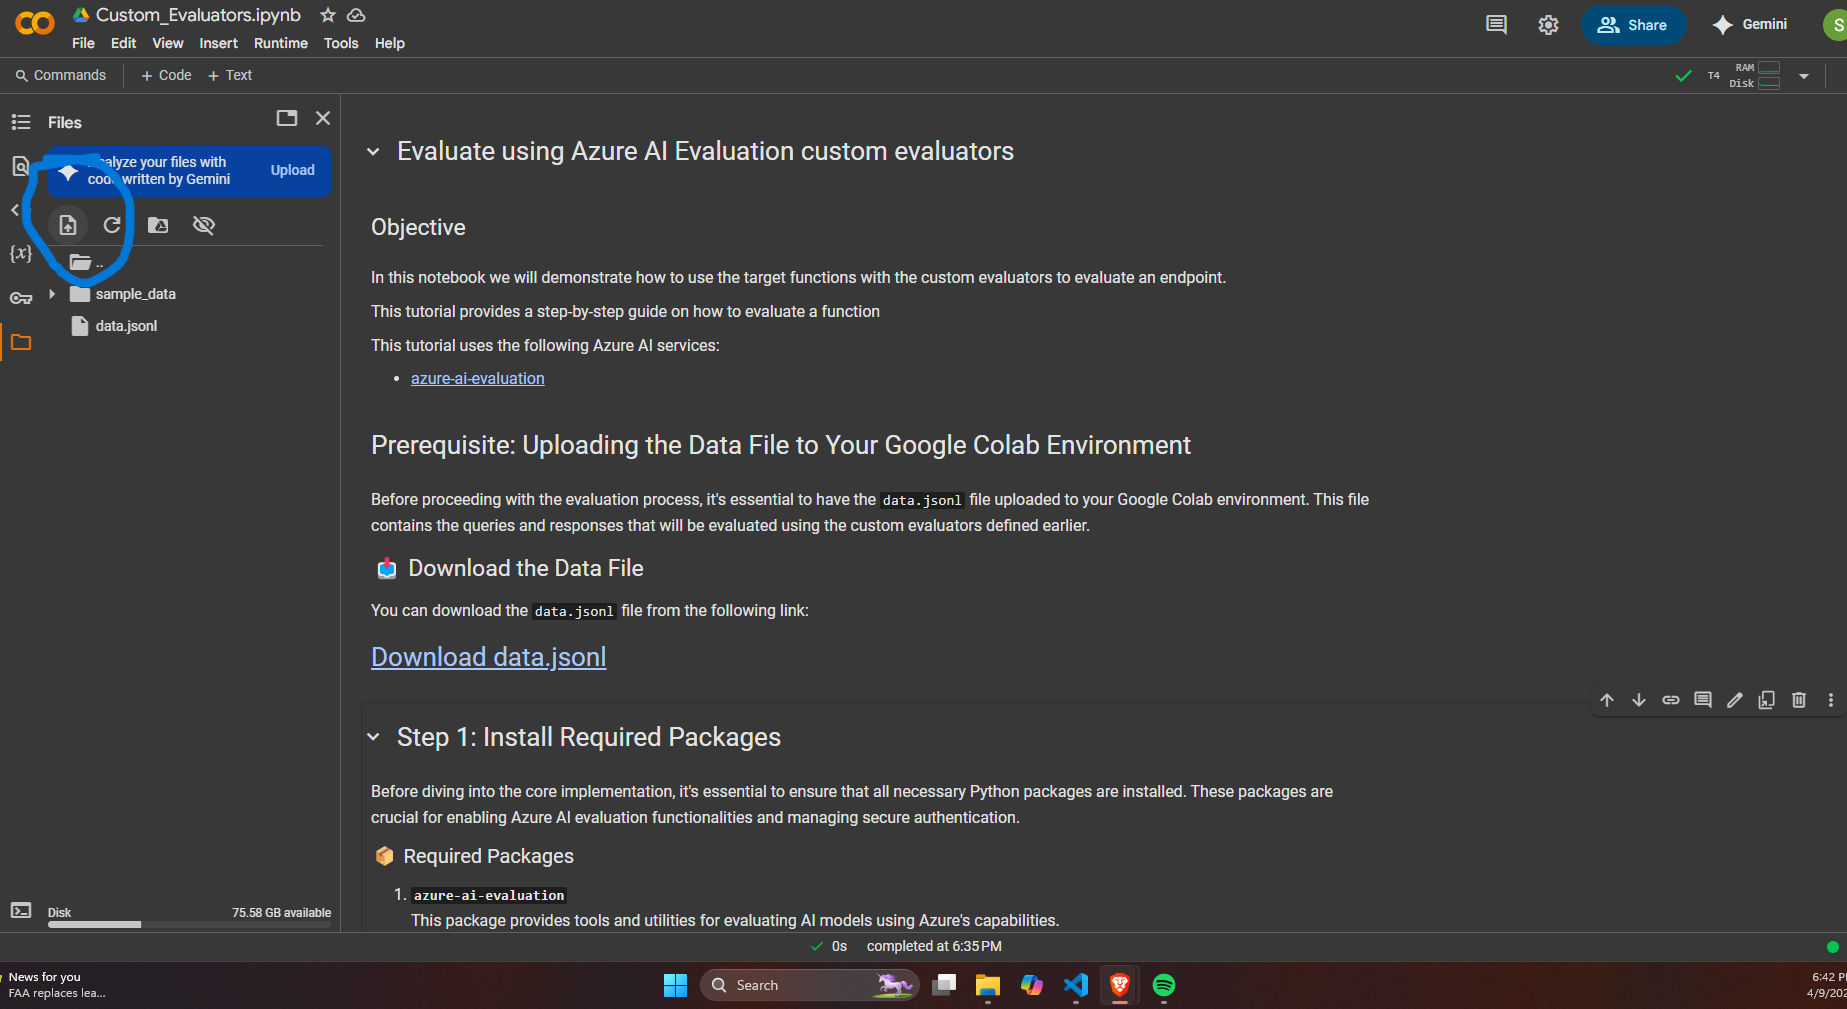

# [Download data.jsonl](https://drive.google.com/file/d/15yqw0hR8waGfJPr6Q96TxIApCp98dzBN/view?usp=sharing)


In [2]:
! pip install azure-ai-evaluation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.7/773.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.1/207.1 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.0/407.0 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.9/987.9 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [21]:
# Cell 1: Import necessary libraries
import os
import json
import pandas as pd
from azure.identity import DefaultAzureCredential
from IPython.display import display, HTML
import warnings

# Suppress pandas warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [33]:
# Cell 2: Setup Azure credentials and configurations
credential = DefaultAzureCredential()

# Initialize Azure AI project and Azure OpenAI connection with your environment variables
azure_ai_project = {
    "subscription_id": "",
    "resource_group_name": "",
    "project_name": "",
}

model_config = {
    "azure_endpoint": "",
    "api_key": "",
    "azure_deployment": "",
    "api_version": ""
}


In [23]:
# Cell 3: Import Azure AI evaluation modules
from azure.ai.evaluation import (
    GroundednessEvaluator,
    CoherenceEvaluator,
    RelevanceEvaluator,
    FluencyEvaluator,
    RetrievalEvaluator
)

# Evaluators Documentation

## Overview
This document provides a brief explanation of each evaluator used in the system.

## Evaluators

### GroundednessEvaluator
- **Purpose**: Assesses how well the response is supported by factual evidence and source material
- **Key Function**: Verifies claims against source documents to ensure factual accuracy

### CoherenceEvaluator
- **Purpose**: Evaluates the logical flow and consistency of the response
- **Key Function**: Checks if the response maintains a clear, logical structure and progression

### RelevanceEvaluator
- **Purpose**: Measures how well the response addresses the specific query
- **Key Function**: Determines if the answer stays focused on the question asked

### FluencyEvaluator
- **Purpose**: Assesses the linguistic quality and readability of the response
- **Key Function**: Evaluates grammar, syntax, and overall language proficiency

### RetrievalEvaluator
- **Purpose**: Evaluates the effectiveness of information retrieval
- **Key Function**: Measures how well relevant information is identified and extracted from source documents

## Usage
All evaluators are initialized with a `model_config` parameter which contains the necessary configuration settings for the evaluation process.

In [24]:
# Cell 4: Initialize evaluators
# Initialize all evaluators that only need model_config
groundedness_eval = GroundednessEvaluator(model_config)
coherence_eval = CoherenceEvaluator(model_config)
relevance_eval = RelevanceEvaluator(model_config)
fluency_eval = FluencyEvaluator(model_config)
retrieval_eval = RetrievalEvaluator(model_config)


In [25]:
# Cell 5: Define functions for better table display
def truncate_text(text, max_length=50):
    """Truncate text with ellipsis if it exceeds max_length"""
    if len(text) > max_length:
        return text[:max_length] + "..."
    return text

def format_dataframe_for_display(df):
    """Format the dataframe for better display"""
    # Create a copy to avoid modifying the original
    display_df = df.copy()

    # Truncate long text fields for display
    for col in ['Context', 'Query', 'Ground Truth']:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(lambda x: truncate_text(x))

    # Round score columns to 2 decimal places
    score_columns = [col for col in display_df.columns if 'Score' in col]
    for col in score_columns:
        display_df[col] = display_df[col].round(2)

    return display_df

def display_styled_table(df):
    """Display a styled HTML table in the notebook"""
    styled_df = df.style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap',
        'font-size': '11px',
        'padding': '5px'
    })

    # Add background color to header
    styled_df = styled_df.set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color', '#f2f2f2'),
                 ('color', 'black'),
                 ('font-weight', 'bold'),
                 ('border', '1px solid #ddd')]
    }, {
        'selector': 'td',
        'props': [('border', '1px solid #ddd')]
    }])

    return styled_df

# Evaluation Function

## Function: evaluate_entry

### Purpose
Evaluates a single entry using multiple evaluators and adds the results to a dataframe.

### Parameters
- `entry`: Dictionary containing the entry to evaluate
  - `query`: The question being asked
  - `context`: The context/reference material
  - `ground_truth`: The expected/correct response
- `results_df`: Pandas DataFrame to store evaluation results

### Evaluation Process
1. **Groundedness Evaluation**
   - Input: query, context, and ground truth
   - Measures factual accuracy against source material

2. **Coherence Evaluation**
   - Input: query and ground truth
   - Assesses logical flow and consistency

3. **Relevance Evaluation**
   - Input: query and ground truth
   - Measures response relevance to the query

4. **Fluency Evaluation**
   - Input: ground truth
   - Evaluates linguistic quality

5. **Retrieval Evaluation**
   - Input: conversation format (query and ground truth)
   - Measures information retrieval effectiveness

### Output
Returns an updated DataFrame containing:
- Context
- Query
- Ground Truth
- Groundedness Score
- Coherence Score
- Relevance Score
- Fluency Score
- Retrieval Score

### Notes
- Each evaluator returns a specific score for its domain
- Results are combined into a single row in the DataFrame
- The function maintains the existing DataFrame structure while adding new results

In [26]:
# Cell 6: Define the evaluation function
def evaluate_entry(entry, results_df):
    """Evaluate a single entry using all evaluators and add to results dataframe"""
    print(f"Evaluating query: {truncate_text(entry['query'], 40)}")

    # Format inputs for each evaluator
    groundedness_input = {
        "query": entry["query"],
        "context": entry["context"],
        "response": entry["ground_truth"]
    }

    coherence_input = {
        "query": entry["query"],
        "response": entry["ground_truth"]
    }

    relevance_input = {
        "query": entry["query"],
        "response": entry["ground_truth"]
    }

    fluency_input = {
        "response": entry["ground_truth"]
    }

    # Format conversation for RetrievalEvaluator
    retrieval_input = {
        "conversation": {
            "messages": [
                {"role": "user", "content": entry["query"]},
                {"role": "assistant", "content": entry["ground_truth"]}
            ]
        }
    }

    # Get all scores
    groundedness_score = groundedness_eval(**groundedness_input)
    coherence_score = coherence_eval(**coherence_input)
    relevance_score = relevance_eval(**relevance_input)
    fluency_score = fluency_eval(**fluency_input)
    retrieval_score = retrieval_eval(**retrieval_input)

    # Create new row for the dataframe
    new_row = {
        'Context': entry['context'],
        'Query': entry['query'],
        'Ground Truth': entry['ground_truth'],
        'Groundedness Score': groundedness_score['groundedness'],
        'Coherence Score': coherence_score['coherence'],
        'Relevance Score': relevance_score['relevance'],
        'Fluency Score': fluency_score['fluency'],
        'Retrieval Score': retrieval_score['retrieval']
    }

    # Use concat with a pre-defined DataFrame
    new_row_df = pd.DataFrame([new_row])
    return pd.concat([results_df, new_row_df], ignore_index=True)

# Main Function

## Function: main

### Purpose
Processes all entries from a JSONL file, evaluates them using multiple metrics, and displays the results in a formatted table.

### Process Flow
1. **Initialization**
   - Creates an empty DataFrame with predefined columns
   - Sets appropriate data types for score columns

2. **Data Processing**
   - Reads entries from 'data.jsonl' file
   - Evaluates each entry using the `evaluate_entry` function
   - Accumulates results in the DataFrame

3. **Results Display**
   - Formats the DataFrame for better readability
   - Applies styling for visual presentation
   - Displays results in console using tabulate or pandas
   - Saves results to Excel with optimized formatting

### Output Formats
1. **Console Display**
   - Formatted table with aligned columns
   - Score values rounded to 2 decimal places
   - Alternating row colors for better readability

2. **Excel Export**
   - Saved as 'evaluation_results.xlsx'
   - Auto-adjusted column widths
   - Maximum column width of 50 characters
   - Preserved formatting and styling

### Features
- **Data Type Management**
  - Proper handling of score columns as float type
  - Prevents data type warnings

- **Visual Styling**
  - Custom table styling for better readability
  - Header highlighting
  - Alternating row colors
  - Centered score columns
  - Left-aligned text columns

- **Error Handling**
  - Fallback display method if tabulate is not available
  - Graceful handling of missing dependencies

### Return Values
- `results_df`: The complete DataFrame with all evaluation results
- `styled_table`: A styled version of the DataFrame for display purposes

In [31]:
# Cell 7: Define the main function with improved table display
def main():
    """Process all entries and display results in a clean, structured table format"""
    print("Starting evaluation of all entries in data.jsonl...\n")

    # Initialize results dataframe with proper dtypes to avoid warnings
    results_df = pd.DataFrame(columns=[
        'Context',
        'Query',
        'Ground Truth',
        'Groundedness Score',
        'Coherence Score',
        'Relevance Score',
        'Fluency Score',
        'Retrieval Score'
    ])

    # Set dtypes for score columns
    for col in results_df.columns:
        if 'Score' in col:
            results_df[col] = results_df[col].astype(float)

    # Process each entry
    with open('data.jsonl', 'r') as file:
        for line in file:
            entry = json.loads(line)
            results_df = evaluate_entry(entry, results_df)

    # Display the formatted table
    print("\n===== EVALUATION RESULTS =====\n")

    # Create a cleaner display dataframe with better formatting
    display_df = format_dataframe_for_display(results_df)

    # Better table styling for Jupyter
    styled_table = display_df.style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap',
        'font-size': '12px',
        'padding': '8px'
    }).set_table_styles([
        {'selector': 'thead th',
         'props': [('background-color', '#4285F4'),
                  ('color', 'white'),
                  ('font-weight', 'bold'),
                  ('border', '1px solid #ddd'),
                  ('text-align', 'center')]},
        {'selector': 'tbody tr:nth-child(even)',
         'props': [('background-color', '#f2f2f2')]},
        {'selector': 'td',
         'props': [('border', '1px solid #ddd')]},
        {'selector': 'th:not(:first-child), td:not(:first-child)',
         'props': [('text-align', 'center')]}
    ]).format({
        'Groundedness Score': '{:.2f}',
        'Coherence Score': '{:.2f}',
        'Relevance Score': '{:.2f}',
        'Fluency Score': '{:.2f}',
        'Retrieval Score': '{:.2f}'
    })

    # Try to use tabulate for console display with clear formatting
    try:
        from tabulate import tabulate
        print(tabulate(display_df, headers='keys', tablefmt='pretty', showindex=False))
    except ImportError:
        # Fall back to pandas display if tabulate not available
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)
        pd.set_option('display.colheader_justify', 'center')
        pd.set_option('display.precision', 2)
        print(display_df.to_string(index=False))


    # Save results to Excel with formatting
    with pd.ExcelWriter('evaluation_results.xlsx', engine='openpyxl') as writer:
        results_df.to_excel(writer, index=False, sheet_name='Evaluation Results')

        # Auto-adjust column widths
        worksheet = writer.sheets['Evaluation Results']
        for i, col in enumerate(results_df.columns):
            max_length = max(
                results_df[col].astype(str).map(len).max(),
                len(col)
            )
            # Add a little extra space
            adjusted_width = (max_length + 2)
            # Set maximum width to avoid extremely wide columns
            adjusted_width = min(adjusted_width, 50)
            worksheet.column_dimensions[chr(65 + i)].width = adjusted_width

    print("Full results also saved to evaluation_results.xlsx with optimized formatting")

    return results_df, styled_table

In [32]:

# Cell 8: Execute the main function
if __name__ == "__main__":
    results_df, styled_table = main()

Starting evaluation of all entries in data.jsonl...

Evaluating query: What is the capital of France?
Evaluating query: Which tent is the most waterproof?
Evaluating query: Which camping table is the lightest?
Evaluating query: How much does TrailWalker Hiking Shoes c...

===== EVALUATION RESULTS =====

+-------------------------------------------------------+----------------------------------------------+-------------------------------------------------------+--------------------+-----------------+-----------------+---------------+-----------------+
|                        Context                        |                    Query                     |                     Ground Truth                      | Groundedness Score | Coherence Score | Relevance Score | Fluency Score | Retrieval Score |
+-------------------------------------------------------+----------------------------------------------+-------------------------------------------------------+--------------------+----------